In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hiddenlayer as hl
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid


In [3]:
train_data = MNIST(
    root="./data/MNIST",
    train=True,
    transform=transforms.ToTensor(),
    download=False
)
train_data_x = train_data.data.type(torch.FloatTensor)/255.0
train_data_x = train_data_x.reshape(train_data_x.shape[0],-1)
train_data_y = train_data.targets
train_loader = Data.DataLoader(
    dataset = train_data_x,
    batch_size=64,
    shuffle= True,
    num_workers=2
)
test_data = MNIST(
    root="./data/MNIST",
    train = False,
    transform = transforms.ToTensor(),
    download=False
)
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = test_data_x.reshape(test_data_x.shape[0],-1)
test_data_y = test_data.targets
print("训练数据集：",train_data_x.shape)
print("测试数据集：",test_data_x.shape)

训练数据集： torch.Size([60000, 784])
测试数据集： torch.Size([10000, 784])


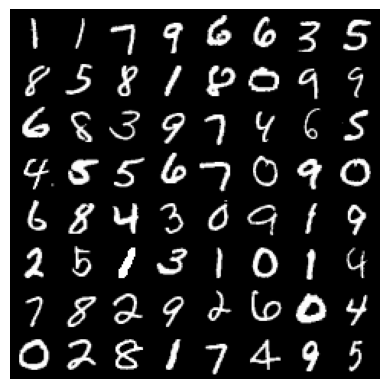

In [4]:
for step,b_x in enumerate(train_loader):
    if step > 0 :
        break
im = make_grid(b_x.reshape((-1,1,28,28)))
im = im.data.numpy().transpose((1,2,0))
plt.figure()
plt.imshow(im)
plt.axis("off")
plt.show()

In [5]:
class EnDecoder(nn.Module):
    def __init__(self):
        super(EnDecoder,self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(784,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,3),
            nn.Tanh(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(3,128),
            nn.Tanh(),
            nn.Linear(128,256),
            nn.Tanh(),
            nn.Linear(256,512),
            nn.Tanh(),
            nn.Linear(512,784),
            nn.Sigmoid()
        )
    def forward(self,x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder,decoder

In [6]:
edmodel = EnDecoder()
print(edmodel)

EnDecoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Tanh()
  )
  (Decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


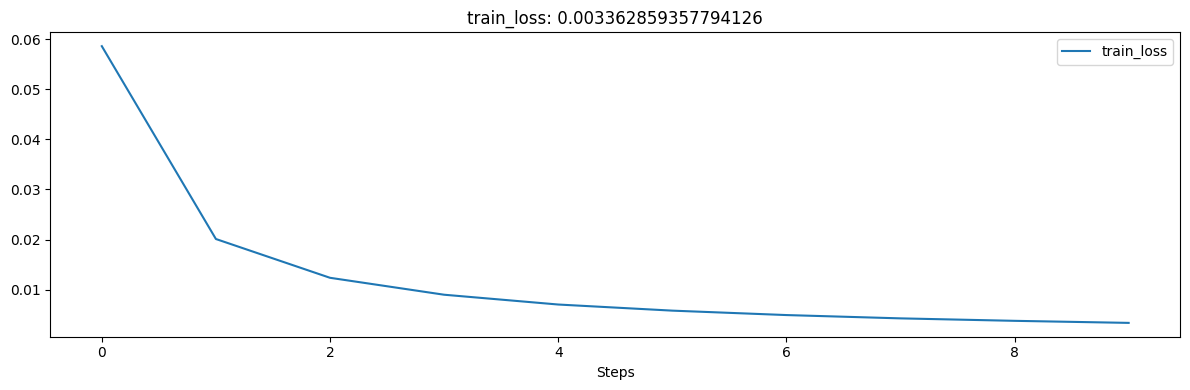

In [7]:
optimizer = torch.optim.Adam(edmodel.parameters(),lr=0.003)
loss_func = nn.MSELoss()
historyl = hl.History()
canvasl = hl.Canvas()
train_num = 0
val_num = 0
for epoch in range(10):
    train_loss_epoch = 0
    for step,b_x in enumerate(train_loader):
        _,output = edmodel(b_x)
        loss = loss_func(output,b_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num+b_x.size(0)
        train_loss = train_loss_epoch / train_num
        historyl.log(epoch,train_loss= train_loss)
        with canvasl:
            canvasl.draw_plot(historyl["train_loss"])


In [8]:
train_ed_x,_ = edmodel(train_data_x)
train_ed_x = train_ed_x.data.numpy()
train_y = train_data_y.data.numpy()
test_ed_x,_ = edmodel(test_data_x)
test_ed_x= test_ed_x.data.numpy()
test_y = test_data_y.data.numpy()

In [10]:
encodersvc = SVC(kernel="rbf",random_state=123)
encodersvc.fit(train_ed_x,train_y)
edsvc_pre = encodersvc.predict(test_ed_x)
print(classification_report(test_y,edsvc_pre))
print("模型精度",accuracy_score(test_y,edsvc_pre))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.93      0.93      1032
           3       0.86      0.88      0.87      1010
           4       0.74      0.67      0.71       982
           5       0.80      0.89      0.84       892
           6       0.92      0.95      0.94       958
           7       0.95      0.89      0.92      1028
           8       0.84      0.74      0.79       974
           9       0.66      0.74      0.69      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

模型精度 0.8632
